# WORD2VEC

Session 3 - Exercice 2

# Load Packages

__Load the necessary packages before starting your work__

In [1]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import gensim
from gensim.test.utils import get_tmpfile
print(gensim.__version__)

4.1.2


In [3]:
# Classic data manipulation libraries
import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unidecode

# Visualization libraries
import seaborn as sns

# NLP Libraries
import gensim
from gensim.test.utils import get_tmpfile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

# Define parameters for notebook import
%matplotlib inline
pd.set_option('display.max_columns', 500)

# Working with default provided dataset
__1- Get the reviews of the Capgemini dataset to begin with__

In [4]:
import os
os.listdir()

['.ipynb_checkpoints',
 'corpus.csv',
 'corpus_total.csv',
 'COURSE_3_EMBEDDING_Homework.ipynb',
 'DM_Embedding_2_2023.ipynb',
 'fournisseurs_energie_top5_forums.json',
 'word2vec.model',
 'word2vec_bigram.model',
 'word2vec_homework.model',
 'word2vec_homework1.model',
 'word2vec_hyperparams.model']

In [5]:
# This is the dataset provided by capgemini
#df = pd.read_json("fournisseurs_energie_top5_forums.json")
#df["text"]

0        Je paie ma facture tous les deux mois en fonct...
1        Engie facture a ses clients des sommes exorbit...
2        Ils me facturent sur le pdl du logement au des...
3        un service client ou il est dur de comprendre ...
4        Excellente expérience avec ENGIE et une interl...
                               ...                        
37289      Le commercial est très bien Le SAV est à revoir
37290      tres professionnel et maintrisant bien le sujet
37291    Je le décrirai d'une façon totalement profesio...
37292    Un rendez-vous qui s'est très bien déroulé, un...
37293    Aucun problème, la conseillère est très profes...
Name: text, Length: 37266, dtype: object

In [8]:
df = pd.read_parquet("reviews_cleaned.parquet")

__2- Create your corpus (it is a list of tokenized the reviews)__

In [10]:
# code here
df = df[df.fournisseur.str.contains("totalenergies")].reset_index(drop=True)

df["text"] = df.verbatim.copy()
corpus = df['text'].tolist()
corpus = [comment.lower() for comment in corpus]
corpus[:3]


['a chaque fois que je contacte au téléphone le service clients de total energie, que ce soit pour le gaz ou l"électricité, je tombe sur une personne agréable, courtoise, à l"écoute, sachant bien conseiller ce qui est très important pour moi. je recommande ce site qui nous fait bénéficier de tarifs préférentiels et j"espère pour longtemps ;-)',
 "installation rapide, prix concurrentiel et surtout promotion de -50€ + 10% de réduction supplémentaire grâce au code 104478135 que j'ai utilisé.\n\nla mise en route a pris 1 semaine, joignable rapidement et facilement par téléphone (même si je préfère par tchat, ils répondent sous 24h)\n\nrien à redire au prix actuel de l'électricité ....",
 "cliente chez total énergie depuis près de deux ans pour ses tarifs qui restent concurrentiels, je vais toutefois changer de fournisseur à cause de leur service client et du manque de transparence dans le suivi des contrats. en effet, je me suis aperçue que total énergie continuait de me prélever l'abonnem

In [12]:
def clean_sentence(sentence, stopwords=False):
    sentence = sentence.lower().strip()
    sentence = unidecode.unidecode(sentence) #remove accents from letters
    sentence = re.sub(r'[^a-z0-9\s]', ' ', sentence) #remove non-alphanumeric characters
    sentence = re.sub(r"\d+", "", sentence) #remove numbers
    sentence = re.sub(r"\s+"," ",sentence) #remove whitespace    
    return sentence

df["clean_text"] = df.text.apply(clean_sentence)
df

Unnamed: 0  page                                  titre  \
0            5000     1  Service impeccable chez Total Energie   
1            5001     1                      Offre immanquable   
2            5002     1              Service client déplorable   
3            5003     1   Nous sommes en litige avec vous des…   
4            5004     1   J’ai été démarché par Yamina YAICHE…   
...           ...   ...                                    ...   
14355       31299   643                            Avis client   
14356       31300   643                            Avis client   
14357       31301   643                            Avis client   
14358       31302   643                            Avis client   
14359       31303   643                            Avis client   

                                                verbatim  \
0      A chaque fois que je contacte au téléphone le ...   
1      Installation Rapide, Prix concurrentiel et sur...   
2      Cliente chez total énergie depuis près de deux...   
3      Nous sommes en litige avec vous des sommes dem...   
4      J’ai été démarché par Yamina YAICHE alors que ...   
...                                                  ...   
14355  Je veux recevoir mai facture et mai consommass...   
14356  Trés dur d avoir des réponse j ai plusieurs co...   
14357  Bjr,ma facture a été divulgué au voisin ,il en...   
14358  Donne de bonnes réponse et explications et inf...   
14359  J'étais très satisfaite de mon contact télépho...   

                                       date  note  \
0                          Il y a 19 heures     5   
1                            ll y a 5 jours     5   
2                            Il y a un jour     1   
3                            ll y a 6 jours     1   
4                              24 nov. 2022     1   
...                                     ...   ...   
14355         le 14/09/2022 par PHILIPPE S.     3   
14356         le 14/09/2022 par PHILIPPE S.     3   
14357         le 14/09/2022 par PHILIPPE S.     3   
14358  le 14/09/2022 par François Eugène N.     5   
14359          le 14/09/2022 par ADELINE G.     5   

                                                 reponse  \
0                                                   None   
1                                                   None   
2      Bonjour Monsieur, Madame,\n\nJ'ai bien pris en...   
3      Bonjour Monsieur, Madame,\n\nJ'ai bien pris en...   
4      Bonjour,\nJ'ai bien pris en compte votre avis ...   
...                                                  ...   
14355                                               None   
14356                                               None   
14357                                               None   
14358                                               None   
14359                                               None   

                               date_experience  \
0       Date de l'expérience: 01 décembre 2022   
1       Date de l'expérience: 27 novembre 2022   
2       Date de l'expérience: 22 novembre 2022   
3       Date de l'expérience: 26 novembre 2022   
4      Date de l'expérience: 15 septembre 2022   
...                                        ...   
14355     suite à une expérience du 05/06/2021   
14356     suite à une expérience du 05/06/2021   
14357     suite à une expérience du 05/06/2021   
14358     suite à une expérience du 05/09/2022   
14359     suite à une expérience du 05/09/2022   

                                             fournisseur         source  \
0      https://fr.trustpilot.com/review/totalenergies.fr     trustpilot   
1      https://fr.trustpilot.com/review/totalenergies.fr     trustpilot   
2      https://fr.trustpilot.com/review/totalenergies.fr     trustpilot   
3      https://fr.trustpilot.com/review/totalenergies.fr     trustpilot   
4      https://fr.trustpilot.com/review/totalenergies.fr     trustpilot   
...                                                  ...            ...   
14355  ht

In [13]:
tokenized_corpus = [re.split('\s+', comment) for comment in df.clean_text]
#print(len(tokenized_corpus))
print(tokenized_corpus[0])
df["tokenized_text"] = tokenized_corpus

['a', 'chaque', 'fois', 'que', 'je', 'contacte', 'au', 'telephone', 'le', 'service', 'clients', 'de', 'total', 'energie', 'que', 'ce', 'soit', 'pour', 'le', 'gaz', 'ou', 'l', 'electricite', 'je', 'tombe', 'sur', 'une', 'personne', 'agreable', 'courtoise', 'a', 'l', 'ecoute', 'sachant', 'bien', 'conseiller', 'ce', 'qui', 'est', 'tres', 'important', 'pour', 'moi', 'je', 'recommande', 'ce', 'site', 'qui', 'nous', 'fait', 'beneficier', 'de', 'tarifs', 'preferentiels', 'et', 'j', 'espere', 'pour', 'longtemps', '']


## Building your own Word2Vec

__1- Load gensim package__

In [14]:
# code here (if you forgot to load the package at the beginning)
from gensim.models import Word2Vec

__2- Create a temporary file by giving an extension and make sure you add ".model" as extension__

In [15]:
# code here
import tempfile

# Create a temporary file with the ".model" extension
path = get_tmpfile("word2vec_homework.model")

__3- Instantiate your word2vec model__


In [16]:
# instantiate the model
model = Word2Vec(tokenized_corpus, window=5, min_count=1, workers=4)


__4- Define the vocabulary of your model__

In [17]:
tokenized_corpus[0]

['a',
 'chaque',
 'fois',
 'que',
 'je',
 'contacte',
 'au',
 'telephone',
 'le',
 'service',
 'clients',
 'de',
 'total',
 'energie',
 'que',
 'ce',
 'soit',
 'pour',
 'le',
 'gaz',
 'ou',
 'l',
 'electricite',
 'je',
 'tombe',
 'sur',
 'une',
 'personne',
 'agreable',
 'courtoise',
 'a',
 'l',
 'ecoute',
 'sachant',
 'bien',
 'conseiller',
 'ce',
 'qui',
 'est',
 'tres',
 'important',
 'pour',
 'moi',
 'je',
 'recommande',
 'ce',
 'site',
 'qui',
 'nous',
 'fait',
 'beneficier',
 'de',
 'tarifs',
 'preferentiels',
 'et',
 'j',
 'espere',
 'pour',
 'longtemps',
 '']

In [18]:
# code here
model.build_vocab(tokenized_corpus)

__5- Train your word2vec model__

In [19]:
# code here
model.train(tokenized_corpus, total_examples=model.corpus_count, epochs=50)

(18149666, 25363350)

__6- Save your word2vec model; give the same path as in your temporary file__

In [20]:
# code here
model.save("word2vec_homework.model")

__Congratulations, you've built your first word2vec model !!!__

__7- Try to repeat the previous steps and change the values of hyperparameters from the model instatiation step__

In [21]:
# code here
model = Word2Vec(tokenized_corpus, window=7, min_count=2, workers=5)
model.build_vocab(tokenized_corpus)
model.train(tokenized_corpus, total_examples=model.corpus_count, epochs=50)
model.save("word2vec_homework1.model")


__8- Load the model you've saved (from the same path as saving path)__

In [22]:
# code here
model = gensim.models.Word2Vec.load("word2vec_homework.model")


__9- Get the weight vector of a word; this is the vector (of numerical) representation of your word__

In [22]:
# code here
word = "quand"
word_vector = list(model.wv[word])
len(word_vector)


100

__10- Get the similarity of some words from your laoded model__

In [23]:
# code here
model.wv.most_similar("quand", topn=6)

[('lorsque', 0.583855926990509),
 ('si', 0.5086742043495178),
 ('comment', 0.45107752084732056),
 ('lorsqu', 0.4376432001590729),
 ('anticipant', 0.42019206285476685),
 ('qu', 0.3883759081363678)]

## Create Word Embedding of Words

__1- Get the embedding matrix of your corpus__

In [24]:
# code here
embedding_matrix = dict()
# START CODE HERE
# embedding_matrix[word]= word2vec representation of the word
for word in model.wv.index_to_key:
    embedding_matrix[word] = list(model.wv[word])

embedding_matrix

{'de': [2.288222,
  -0.6587749,
  1.2929566,
  1.0146308,
  -0.18453214,
  0.52490914,
  -1.2419872,
  0.32052433,
  0.66646785,
  0.4014606,
  0.6035597,
  1.2238541,
  1.1399664,
  0.6102582,
  -0.8357479,
  0.09224996,
  -0.23128241,
  -0.6008168,
  0.08205428,
  0.07023491,
  -0.3942158,
  -0.42543426,
  0.9470076,
  -1.9822901,
  -0.735737,
  -1.3865815,
  0.7784515,
  -0.4681978,
  1.2170359,
  1.2164816,
  -1.067966,
  -2.0335035,
  0.24630359,
  1.1142806,
  -0.1248637,
  0.5547618,
  1.4297556,
  -1.1336538,
  -2.7316914,
  0.337994,
  -1.2832003,
  1.2951766,
  0.47148106,
  0.12199589,
  -1.7988871,
  0.38600415,
  0.47691938,
  -0.15453628,
  -1.0603632,
  1.5836066,
  0.90468687,
  0.56789976,
  0.96679866,
  -1.5238763,
  -1.2151695,
  -0.5563612,
  -0.97785836,
  2.3895333,
  -0.91270286,
  -0.58816385,
  -1.6829294,
  0.9341242,
  -0.14644097,
  -0.09467656,
  0.6274101,
  -0.4582523,
  -0.696646,
  -0.74877125,
  0.48802075,
  -0.66712064,
  -0.08755578,
  1.1872231,
 

__2- Transform it to a pandas DataFrame and look into few lines of you embedding matrix__

In [25]:
# code here
embedding_matrix = pd.DataFrame(embedding_matrix)
embedding_matrix.head()
embedding_matrix.shape

(100, 8080)

## Discovering Knowledge With Embedding Matrix

## 1- Dimension Reduction (PCA)

__1.1- Instantiate a PCA with whatever number of components that you want__

In [26]:
# code here
pca = PCA(n_components=2)

__1.2- Fit your PCA to your data; make sure your words are the rows of your data__

In [27]:
# code here
word_vector = model.wv
# 2D numpy arrays
word_vector_matrix = word_vector.vectors
# code here
pca.fit(word_vector_matrix)

PCA(n_components=2)

__1.3- Get the explained variance ratio of your PCA__

In [28]:
# code here
print(pca.explained_variance_ratio_)

[0.04419958 0.03011993]


__1.4- Apply your PCA to your data__

In [33]:
len(word_vector_matrix)

8080

In [29]:
# code here
pca_data = pca.transform(word_vector_matrix)

__1.5- Get a look (a plot) of the PCA on your data__

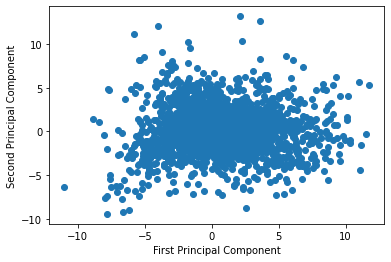

In [30]:
# code here
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

## 2- Dimension reduction (T-SNE)

__2.1- Instantiate your TSNE method__

In [31]:
# code here
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)

__2.2- Fit your data and transform it__

In [32]:
# code here
tsne_model = tsne.fit_transform(word_vector_matrix)

__2.3- Get a look on your TSNE transformation__

In [34]:
# code here
tsne_model

array([[ 60.59209 ,  62.132095],
       [ 40.994087,  22.1186  ],
       [ 45.38518 ,  23.481085],
       ...,
       [-45.22295 ,  23.218246],
       [-35.004158, -36.85489 ],
       [ 59.305016,  49.22601 ]], dtype=float32)

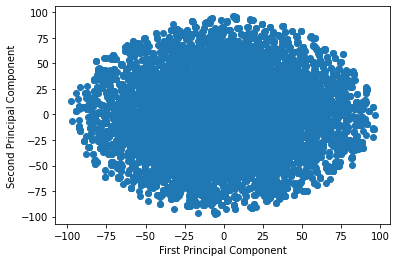

In [35]:
plt.scatter(tsne_model[:, 0], tsne_model[:, 1])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

## Generating your Reviews Embedding Matrix

__1- For each reviews, aggregate (average) the weight vector of terms it comprises__

In [38]:
import numpy as np

def aggregate_review_vectors(reviews, word2vec_model):
    review_vectors = []
    for review in reviews:
        review_words = review.split()
        review_vector = np.zeros(word2vec_model.vector_size)
        count = 0
        for word in review_words:
            if word in word2vec_model.wv:
                word_vector = word2vec_model.wv[word]
                review_vector += word_vector
                count += 1
        if count > 0:
            review_vector /= count
        review_vectors.append(review_vector)
    return review_vectors

#reviews = [review1, review2, ...] # list of reviews as strings
review_vectors = aggregate_review_vectors(df["text"], model)
len(review_vectors)

14360

In [47]:
review_vectors = np.array(review_vectors)


[0.1798653  0.08589637]


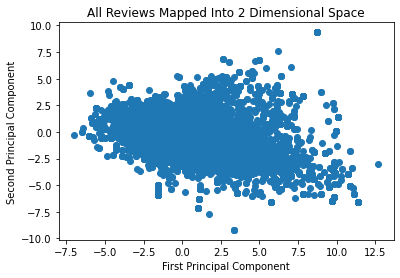

In [43]:
pca = PCA(n_components=2)
pca.fit(review_vectors)
print(pca.explained_variance_ratio_)

pca_data = pca.transform(review_vectors)
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.title("All Reviews Mapped Into 2 Dimensional Space")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

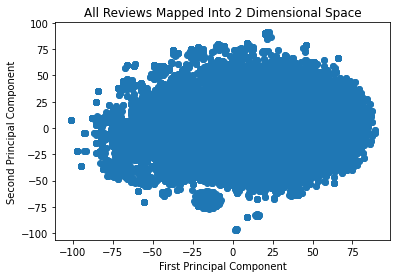

In [48]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
tsne_model = tsne.fit_transform(review_vectors)
plt.scatter(tsne_model[:, 0], tsne_model[:, 1])
plt.title("All Reviews Mapped Into 2 Dimensional Space")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

__2- There you go, you build your first word2vec embedding matrix for further analysis__

# Working with our webscraped data

__1- Get the data and look at its shape__

In [214]:
# This is the preprocessed data from the previous homework for this homework we shall be using the dataset provided by capgemini
df_group = pd.read_csv("corpus_total.csv")
df_group.shape

(200, 15)

In [215]:
df_group.head()

index                                               text  grade  \
0    200  Service électricité très bien mais si…\nServic...      1   
1    201  Honteux\nHonteux, si je pouvais mettre zéro il...      1   
2    202  incompréhension avec le service client…\nincom...      1   
3    203  très satisfaite\nEn souscrivant en ligne je vo...      5   
4    204  Très bonne application\nTrès bonne application...      5   

               date company  n_words  \
0   03 février 2023   total       57   
1   02 février 2023   total       67   
2   01 février 2023   total       89   
3   31 janvier 2023   total       40   
4   29 janvier 2023   total       66   

                                          clean_text  \
0  service electricite tres bien mais si service ...   
1  honteux honteux si je pouvais mettre zero ils ...   
2  incomprehension avec le service client incompr...   
3  tres satisfaite en souscrivant en ligne je vou...   
4  tres bonne application tres bonne application ...   

                                      tokenized_text  \
0  ['service', 'electricite', 'tres', 'bien', 'si...   
1  ['honteux', 'honteux', 'si', 'pouvais', 'mettr...   
2  ['incomprehension', 'service', 'client', 'inco...   
3  ['tres', 'satisfaite', 'souscrivant', 'ligne',...   
4  ['tres', 'bonne', 'application', 'tres', 'bonn...   

                                             bigrams  \
0  [('service', 'electricite'), ('electricite', '...   
1  [('honteux', 'honteux'), ('honteux', 'si'), ('...   
2  [('incomprehension', 'service'), ('service', '...   
3  [('tres', 'satisfaite'), ('satisfaite', 'sousc...   
4  [('tres', 'bonne'), ('bonne', 'application'), ...   

                                            trigrams  \
0  [('service', 'electricite', 'tres'), ('electri...   
1  [('honteux', 'honteux', 'si'), ('honteux', 'si...   
2  [('incomprehension', 'service', 'client'), ('s...   
3  [('tres', 'satisfaite', 'souscrivant'), ('sati...   
4  [('tres', 'bonne', 'application'), ('bonne', '...   

                                            wordDict  \
0  {'infos': 0, 'souci': 0, 'cette': 0, 'jamais':...   
1  {'infos': 0, 'souci': 0, 'cette': 0, 'jamais':...   
2  {'infos': 0, 'souci': 0, 'cette': 0, 'jamais':...   
3  {'infos': 0, 'souci': 0, 'cette': 0, 'jamais':...   
4  {'infos': 0, 'souci': 0, 'cette': 0, 'jamais':...   

                                               tfBOW  \
0  {'infos': 0.0, 'souci': 0.0, 'cette': 0.0, 'ja...   
1  {'infos': 0.0, 'souci': 0.0, 'cette': 0.0, 'ja...   
2  {'infos': 0.0, 'souci': 0.0, 'cette': 0.0, 'ja...   
3  {'infos': 0.0, 'souci': 0.0, 'cette': 0.0, 'ja...   
4  {'infos': 0.0, 'souci': 0.0, 'cette': 0.0, 'ja...   

                                               tfIDF  \
0  {'infos': 0.0, 'souci': 0.0, 'cette': 0.0, 'ja...   
1  {'infos': 0.0, 'souci': 0.0, 'cette': 0.0, 'ja...   
2  {'infos': 0.0, 'souci': 0.0, 'cette': 0.0, 'ja...   
3  {'infos': 0.0, 'souci': 0.0, 'cette': 0.0, 'ja...   
4  {'infos': 0.0, 'souci': 0.0, 'cette': 0.0, 'ja...   

                                     lemmatized_text  \
0  ['service', 'electricite', 'tres', 'bien', 'si...   
1  ['honteux', 'honteux', 'si', 'pouvais', 'mettr...   
2  ['incomprehension', 'service', 'client', 'inco...   
3  ['tres', 'satisfaite', 'souscrivant', 'ligne',...   
4  ['tres', 'bonne', 'application', 'tres', 'bonn...   

                                        stemmed_text  
0  ['servic', 'electricit', 'tre', 'bien', 'si', ...  
1  ['honteux', 'honteux', 'si', 'pouv', 'mettr', ...  
2  ['incomprehens', 'servic', 'client', 'incompre...  
3  ['tre', 'satisfait', 'souscriv', 'lign', 'voul...  
4  ['tre', 'bon', 'appliqu', 'tre', 'bon', 'appli...

__2- Look into few lines of your data and see variables types__

In [216]:
# your code here
df_group.dtypes

index               int64
text               object
grade               int64
date               object
company            object
n_words             int64
clean_text         object
tokenized_text     object
bigrams            object
trigrams           object
wordDict           object
tfBOW              object
tfIDF              object
lemmatized_text    object
stemmed_text       object
dtype: object

In [217]:
#lists are turned into strings, convert them back to lists
import ast

df_group["tokenized_text"] = [ast.literal_eval(i) for i in df_group.tokenized_text]
df_group["bigrams"] = [ast.literal_eval(i) for i in df_group.bigrams]
df_group["trigrams"] = [ast.literal_eval(i) for i in df_group.trigrams]
df_group["lemmatized_text"] = [ast.literal_eval(i) for i in df_group.lemmatized_text]
df_group["stemmed_text"] = [ast.literal_eval(i) for i in df_group.stemmed_text]


In [218]:
import tempfile

# Create a temporary file with the ".model" extension
path = get_tmpfile("word2vec.model")

In [219]:
tokenized_corpus = df_group["tokenized_text"].to_list()

In [220]:
model = Word2Vec(tokenized_corpus, window=5, min_count=1, workers=4)

In [221]:
model.build_vocab(tokenized_corpus)

In [222]:
model.train(tokenized_corpus, total_examples=model.corpus_count, epochs=50)

(317691, 359150)

In [223]:
model.save("word2vec.model")

In [224]:
model = Word2Vec(tokenized_corpus, window=3, min_count=1, workers=5)
model.build_vocab(tokenized_corpus)
model.train(tokenized_corpus, total_examples=model.corpus_count, epochs=50)
model.save("word2vec_hyperparams.model")


In [225]:
model = gensim.models.Word2Vec.load("word2vec.model")

word = "catastrophe"
word_vector = list(model.wv[word])
word_vector


[-0.09419684,
 0.3053274,
 0.058083456,
 0.031673208,
 0.0059190295,
 -0.37929896,
 0.08173819,
 0.47746736,
 -0.23107596,
 -0.1658653,
 -0.17025328,
 -0.3583074,
 -0.005123867,
 0.13975962,
 0.1558009,
 -0.18593888,
 -0.010147404,
 -0.35759178,
 0.05568623,
 -0.53949076,
 0.19276556,
 0.16169536,
 0.15540782,
 -0.1443574,
 -0.065779746,
 0.010164353,
 -0.28976908,
 -0.17440015,
 -0.20411326,
 0.06479823,
 0.3098456,
 0.031823937,
 0.04132397,
 -0.17806856,
 -0.033242375,
 0.27932358,
 -0.025699122,
 -0.1922107,
 -0.13993241,
 -0.4501324,
 0.014497668,
 -0.18630165,
 -0.080624916,
 0.01734072,
 0.17837629,
 -0.114017144,
 -0.15959619,
 -0.020751044,
 0.111337386,
 0.2877302,
 0.090009324,
 -0.14468409,
 -0.069656216,
 -0.06843435,
 -0.18844466,
 0.14224002,
 0.08063003,
 -0.07294604,
 -0.3381492,
 0.06391584,
 0.047838986,
 0.04987346,
 -0.072827704,
 0.055650294,
 -0.3342538,
 0.20345916,
 0.026848419,
 0.14189367,
 -0.30020076,
 0.38862398,
 -0.18665265,
 0.15560928,
 0.25834078,
 -0

In [226]:
model.wv.most_similar(word, topn=6)

[('justice', 0.9991200566291809),
 ('point', 0.9990102648735046),
 ('restrictions', 0.9989883303642273),
 ('genre', 0.9989489316940308),
 ('dernier', 0.998913049697876),
 ('apparait', 0.998852014541626)]

In [227]:
embedding_matrix = dict()

for word in model.wv.index_to_key:
    embedding_matrix[word] = list(model.wv[word])

embedding_matrix

{'service': [-0.075377755,
  0.6929536,
  -0.106331915,
  0.23909035,
  0.24818778,
  -0.74233055,
  0.31392372,
  1.0325568,
  -0.6480442,
  -0.27190316,
  -0.20814437,
  -0.64633816,
  0.0809063,
  0.39308673,
  0.056665458,
  -0.57086897,
  -0.12867458,
  -0.22437277,
  0.14943643,
  -0.7965049,
  0.49756512,
  0.34178686,
  0.6029866,
  -0.0025675816,
  -0.057216063,
  -0.07546672,
  -0.33752272,
  0.22731106,
  -0.45224112,
  -0.09428357,
  0.48679546,
  -0.39851218,
  0.3280966,
  -0.4946388,
  0.07945506,
  0.4029424,
  0.1574188,
  -0.42340335,
  -0.33243194,
  -0.77013624,
  -0.39132017,
  -0.14988919,
  -0.11449674,
  0.052109268,
  0.40937066,
  -0.26571342,
  -0.21119723,
  -0.056353696,
  0.20974854,
  0.3865228,
  0.058890868,
  -0.31499553,
  -0.32675678,
  -0.3277946,
  -0.10741183,
  0.037090603,
  0.13001028,
  -0.00923318,
  -0.7973967,
  0.09582828,
  0.125816,
  0.10352936,
  -0.015636716,
  0.15483822,
  -0.51177275,
  0.6232831,
  0.29458138,
  0.18364325,
  -0.6

In [228]:
embedding_matrix = pd.DataFrame(embedding_matrix)
print(embedding_matrix.shape)
embedding_matrix.head()

(100, 2268)


service       jai      plus     total      tres    client      chez  \
0 -0.075378 -0.157725 -0.203198 -0.203092 -0.291353 -0.034099 -0.242460   
1  0.692954  0.557289  0.535992  0.767408  0.807054  0.673955  0.671502   
2 -0.106332  0.152120  0.131556  0.106475 -0.085540 -0.088094  0.124213   
3  0.239090  0.081464  0.003261  0.122957  0.235175  0.151770  0.133241   
4  0.248188 -0.086414 -0.164344  0.221805  0.547576  0.271001  0.074151   

    contrat  consommation      mois      cest   energie      bien      fait  \
0 -0.256451     -0.266391 -0.250252 -0.170648 -0.244494 -0.207971 -0.185068   
1  0.590532      0.599826  0.496468  0.614562  0.656507  0.683251  0.668476   
2  0.244927      0.086994  0.167097  0.123001  0.080372  0.066603  0.090063   
3  0.035187      0.082502  0.033034  0.023521  0.164605  0.120605  0.057162   
4 -0.016935     -0.064776 -0.236608 -0.030110  0.180802  0.114212 -0.044737   

     depuis      rien   facture      tout   demande     faire        si  \
0 -0.226551 -0.112890 -0.214545 -0.144128 -0.228109 -0.198824 -0.233401   
1  0.571099  0.667803  0.619152  0.679340  0.512622  0.684264  0.709651   
2  0.088869  0.019472  0.171805  0.258066  0.074081  0.081603  0.096514   
3  0.048235  0.099367 -0.031811  0.158957  0.044473  0.032884  0.070846   
4 -0.150735 -0.073228 -0.146611  0.142832 -0.142556 -0.107725  0.035690   

      euros  fournisseur  toujours       gaz     cette       car     suivi  \
0 -0.219487    -0.248360 -0.206143 -0.269778 -0.200054 -0.187714 -0.310447   
1  0.620592     0.821843  0.653244  0.605551  0.622691  0.654577  0.746255   
2  0.176081    -0.006978  0.044544  0.093891  0.093949  0.126923 -0.037754   
3 -0.026556     0.226333  0.046973  0.061106 -0.011507  0.049024  0.228328   
4 -0.196762     0.304522 -0.051641 -0.052798 -0.115510 -0.097771  0.045221   

       sans        ca    aucune   clients   reponse     alors     apres  \
0 -0.302656 -0.195205 -0.289497 -0.040214 -0.187612 -0.219547 -0.260230   
1  0.615051  0.588601  0.577219  0.618379  0.441216  0.624830  0.532541   
2  0.178324  0.104623  0.036388  0.090587  0.057997  0.185229  0.187218   
3  0.015699  0.078263  0.064522  0.183115  0.079405  0.032814 -0.022132   
4 -0.086582 -0.144967 -0.037865  0.134840 -0.060903 -0.120795 -0.180692   

       prix      fuir  souscription      donc  totalenergies      site  \
0 -0.219500 -0.136524     -0.309028 -0.240281      -0.198160 -0.224900   
1  0.638753  0.585336      0.581585  0.662163       0.689312  0.580551   
2  0.197401  0.056637      0.190392  0.095983       0.021831  0.138738   
3  0.083029  0.144047     -0.032962  0.016817       0.175817  0.050687   
4  0.060515  0.055743      0.040898 -0.124997       0.115287 -0.008084   

   telephone     comme  probleme     avoir     aucun     payer    compte  \
0  -0.117272 -0.245676 -0.225220 -0.219788 -0.172732 -0.146549 -0.295402   
1   0.622670  0.666485  0.646303  0.592736  0.589579  0.482850  0.721502   
2   0.079334  0.149596  0.088144  0.075125  0.049522  0.114920  0.118637   
3   0.006913  0.087976  0.132596  0.083438  0.216856 -0.041955  0.033007   
4  -0.074516 -0.074430 -0.016101 -0.196884 -0.070755 -0.211286 -0.096667   

   factures      nest  recommande      fois  lapplication  conseiller  \
0 -0.194532 -0.271321   -0.279827 -0.201578     -0.311468   -0.227985   
1  0.687069  0.597922    0.555460  0.718048      0.635650    0.706391   
2  0.115452  0.070710   -0.019189  0.088074      0.010429    0.136421   
3  0.024133  0.034815    0.216866  0.043292      0.243281    0.016615   
4 -0.007800 -0.030068    0.327801 -0.008044      0.201667   -0.013131   

        edf       dun  delectricite       nai       bon     bonne  satisfait  \
0 -0.223230 -0.213388     -0.209692 -0.151387 -0.171388 -0.274952  -0.294603   
1  0.684039  0.558645      0.670843  0.610948  0.672234  0.628743   0.482077   
2  0.128387  0.113786      0.081191  0.038685 -0.112700  0.041042  -0.134477   
3  0.084125  0.096491      0.118590  0.048461 

In [229]:
#PCA
pca = PCA(n_components=2)
word_vector = model.wv
word_vector_matrix = word_vector.vectors
pca.fit(word_vector_matrix)

PCA(n_components=2)

In [230]:
print(pca.explained_variance_ratio_)

[0.9366463  0.03184614]


In [231]:
# code here
pca_data = pca.transform(word_vector_matrix)

__1.5- Get a look (a plot) of the PCA on your data__

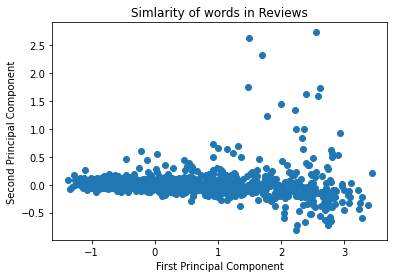

In [235]:
# code here
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Simlarity of words in Reviews")
plt.show()

In [258]:
# TSNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15)
tsne_model = tsne.fit_transform(word_vector_matrix)
tsne_model

array([[ 57.283897 ,   4.985058 ],
       [ 66.86536  ,   8.725827 ],
       [ 73.369934 ,   9.224349 ],
       ...,
       [ -5.3909264, -13.350165 ],
       [ -5.1138225, -13.427198 ],
       [  3.6208544,  36.09689  ]], dtype=float32)

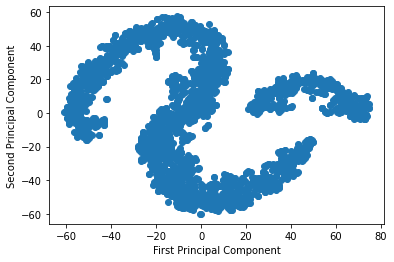

In [259]:
plt.scatter(tsne_model[:, 0], tsne_model[:, 1])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

#### Generating your Reviews Embedding Matrix

In [244]:
import numpy as np

def aggregate_review_vectors(reviews, word2vec_model):
    review_vectors = np.zeros((len(reviews), word2vec_model.vector_size))
    #print(review_vectors.shape)
    for i, review in enumerate(reviews):
        review_words = review.split()
        
        review_vector = np.zeros(word2vec_model.vector_size)
        count = 0
        for word in review_words:
            if word in word2vec_model.wv:
                word_vector = word2vec_model.wv[word]
                review_vector += word_vector
                count += 1
        if count > 0:
            review_vector /= count
        #review_vectors.append(review_vector)
        review_vectors[i,:] = review_vector
    return review_vectors

#reviews = [review1, review2, ...] # list of reviews as strings
review_vectors = aggregate_review_vectors(df_group["text"], model)

(200, 100)


In [248]:
review_vectors = pd.DataFrame(review_vectors, index=df_group.index)


In [249]:
display(review_vectors)

0         1         2         3         4         5         6   \
0   -0.123654  0.418302  0.045875  0.069182  0.031733 -0.490502  0.117744   
1   -0.109962  0.414590  0.051923  0.062244  0.006586 -0.505719  0.113778   
2   -0.140121  0.520732  0.051987  0.082292  0.039116 -0.631604  0.153089   
3   -0.097815  0.287639  0.046050  0.032329 -0.005807 -0.349485  0.068776   
4   -0.180608  0.470940  0.078959  0.042075 -0.010801 -0.553062  0.094130   
..        ...       ...       ...       ...       ...       ...       ...   
195 -0.148861  0.446529  0.083003  0.088669  0.127516 -0.443661  0.107866   
196 -0.194083  0.510501  0.097432  0.049765  0.056075 -0.560531  0.069398   
197 -0.057015  0.193350  0.067809  0.001569 -0.004913 -0.235431  0.038520   
198 -0.198976  0.617941  0.068833  0.174726 -0.043428 -0.763431  0.143115   
199  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           7         8         9         10        11        12        13  \
0    0.658732 -0.322503 -0.225026 -0.193541 -0.483660  0.010696  0.194386   
1    0.636666 -0.303359 -0.224950 -0.202436 -0.489051  0.002176  0.200741   
2    0.795821 -0.418824 -0.264265 -0.242879 -0.575758  0.021488  0.245700   
3    0.446229 -0.218200 -0.149543 -0.155644 -0.342544  0.004511  0.118917   
4    0.759054 -0.363764 -0.248097 -0.246467 -0.566656  0.014589  0.194290   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.737139 -0.376169 -0.197532 -0.212040 -0.487005  0.060767  0.172100   
196  0.868985 -0.450903 -0.165612 -0.288612 -0.487826  0.056707  0.155074   
197  0.275342 -0.119266 -0.074648 -0.101825 -0.214092  0.007622  0.070340   
198  1.008862 -0.589805 -0.352813 -0.326915 -0.792080 -0.084246  0.277297   
199  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           14        15        16        17        18        19        20  \
0    0.161133 -0.267591 -0.021754 -0.403518  0.071725 -0.678453  0.251728   
1    0.182929 -0.253414 -0.029944 -0.445247  0.067816 -0.694183  0.263356   
2    0.219662 -0.340833 -0.046185 -0.505746  0.102444 -0.841391  0.327169   
3    0.131636 -0.185650 -0.010634 -0.326562  0.050214 -0.512578  0.166034   
4    0.196252 -0.287399  0.017385 -0.497309  0.067512 -0.838211  0.234701   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.087203 -0.262062  0.012259 -0.280749 -0.007408 -0.747073  0.221196   
196  0.074340 -0.218496  0.057294 -0.419140  0.051899 -0.854237  0.209478   
197  0.092491 -0.093791 -0.007555 -0.178299  0.040329 -0.310389  0.112944   
198  0.237993 -0.338219 -0.000703 -0.722269  0.110518 -1.140625  0.319668   
199  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           21        22        23        24        25        26        27  \
0    0.209797  0.238283 -0.156623 -0.097056  0.016451 -0.345454 -0.138125   
1    0.218059  0.215494 -0.192867 -0.102747  0.025590 -0.363158 -0.193423   
2    0.273022  0.268506 -0.192179 -0.121910  0.005015 -0.427600 -0.178464   
3    0.147012  0.125751 -0.135936 -0.065971  0.014967 -0.248222 -0.148020   
4    0.206832  0.191070 -0.242250 -0.077984  0.011771 -0.436140 -0.268131   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.132386  0.287968 -0.146271 -0.065851  0.058948 -0.324950 -0.103448   
196  0.161883  0.158131 -0.280335 -0.086407 -0.013175 -0.425606 -0.237213   
197  0.096782  0.070100 -0.091976 -0.055999 -0.001617 -0.173877 -0.079552   
198  0.237415  0.253195 -0.278030 -0.241316 -0.008514 -0.557478 -0.373129   
199  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           28        29        30        31        32        33        34  \
0   -0.274664  0.051676  0.409546 -0.005760  0.089603 -0.251534 -0.019327   
1   -0.263085  0.069656  0.429641  0.030518  0.095278 -0.263290 -0.035754   
2   -0.336346  0.047477  0.482158 -0.035389  0.129668 -0.334143 -0.023957   
3  

[0.75243734 0.14218803]


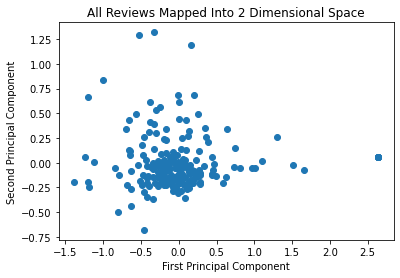

In [251]:
pca = PCA(n_components=2)
pca.fit(review_vectors)
print(pca.explained_variance_ratio_)

pca_data = pca.transform(review_vectors)
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.title("All Reviews Mapped Into 2 Dimensional Space")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

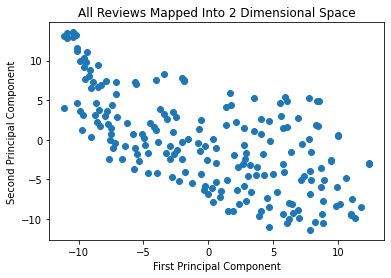

In [266]:
#TSNE 
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
tsne_model = tsne.fit_transform(review_vectors)
plt.scatter(tsne_model[:, 0], tsne_model[:, 1])
plt.title("All Reviews Mapped Into 2 Dimensional Space")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

#### BONUS: Model with bigrams
Make predictions with this model as well

In [190]:
path = get_tmpfile("word2vec_bigram.model")
tokenized_corpus = df_group["bigrams"].to_list()
model = Word2Vec(tokenized_corpus, window=5, min_count=1, workers=4)
model.build_vocab(tokenized_corpus)
model.train(tokenized_corpus, total_examples=model.corpus_count, epochs=50)
model.save("word2vec_bigram.model")

In [193]:
df_group.columns

Index(['text', 'grade', 'date', 'company', 'n_words', 'clean_text',
       'tokenized_text', 'bigrams', 'trigrams', 'wordDict', 'tfBOW', 'tfIDF',
       'lemmatized_text', 'stemmed_text'],
      dtype='object')

#### BONUS: Model with stemmed text 

In [202]:
path = get_tmpfile("word2vec_stemmed.model")
tokenized_corpus = df_group["stemmed_text"].to_list()
model = Word2Vec(tokenized_corpus, window=5, min_count=1, workers=4)
model.build_vocab(tokenized_corpus)
model.train(tokenized_corpus, total_examples=model.corpus_count, epochs=50)
model.save("word2vec_bigram.model")

In [203]:
embedding_matrix = dict()

for word in model.wv.index_to_key:
    embedding_matrix[word] = list(model.wv[word])

pd.DataFrame(embedding_matrix)

factur    servic       jai    client      plus   contrat       eni  \
0  -0.192376  1.241123  0.190635  1.135592 -0.212558 -0.118242 -0.128875   
1   0.505786 -0.484637 -0.042257  0.134765  0.726858  0.365427  0.738955   
2  -0.225938  0.126560 -0.229030 -0.144560 -0.324305 -0.826724  0.150929   
3  -0.160131  0.538819  0.460698  0.718713 -0.463350  0.808598  0.808695   
4   0.897806 -1.766442 -0.593963 -1.747018  0.528164 -0.129670 -0.289271   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.360428  0.390057  0.692725 -0.179260  0.175420  1.113058  0.407021   
96  0.265011  0.076540  0.406725  0.002282 -0.221431  0.461428 -0.232319   
97  0.513504  0.033688  0.140289  0.217320 -0.121354  0.813972  0.466633   
98  0.214517 -0.401029  0.236716 -0.081594 -0.522814 -0.295586 -0.702975   
99 -0.447599 -0.353373  0.136157 -0.036343  0.018936 -0.041443  0.068184   

        chez      cest      mois   consomm      tout       san      fait  \
0  -0.267833 -0.315467 -0.790106 -0.647192 -0.230371  0.421518 -0.632604   
1   0.313923  1.090134  0.836715  0.976641 -0.048963  0.718357 -0.241419   
2  -0.424053  0.869279 -0.413951 -0.670331  0.010400 -0.217402  0.600387   
3   1.182335  0.559882 -0.271316 -0.876797  0.332911  0.110232  0.153203   
4  -1.104765  1.222356  0.734602  0.832804 -0.117899  0.506426  0.113434   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.612930  0.752295  0.334360 -0.608438  0.112206  0.941786  1.184950   
96  0.672449 -0.717086  0.375789 -0.376300  0.147935  0.120951  0.296824   
97  0.916128 -1.080952 -0.031443 -0.100154 -0.521540  0.133187 -1.303517   
98 -1.041978 -0.140137  0.261827  0.420999  0.191952  0.285990 -0.483737   
99  0.522984 -0.317818 -0.639509  0.115588 -0.341038 -0.323833 -0.326130   

       aucun  fournisseur       tre     total    demand      fuir      bien  \
0   0.155373     0.781833 -0.048456 -0.590352 -0.266696  0.357519 -0.201402   
1   0.285806     0.081067 -0.222281 -0.297939  0.509081 -0.006070  0.121941   
2  -0.156775    -0.632214 -0.801318 -1.480768 -0.188742  0.174763  0.247863   
3  -0.793396     1.296174 -0.491313  0.567230  0.071544  0.397398 -0.333252   
4  -0.526920    -0.732403 -0.894566 -1.242105  0.808508 -0.341560 -0.186376   
..       ...          ...       ...       ...       ...       ...       ...   
95  0.661856    -0.293443 -0.646641 -0.702843  1.181018 -0.564868  0.602928   
96 -0.197804    -0.029036  0.157072  2.054790  0.247072  0.081803  0.007957   
97 -0.029450    -0.097140 -0.267675  0.250347 -0.446510 -0.336591 -0.617749   
98  0.587668     0.363037  0.376471  0.438127  0.115475  0.523220 -0.485971   
99 -0.572399     0.270540  0.464591  0.394936 -0.609314 -0.647522  0.371596   

        rien      fair     energ      prix       pai       gaz    prelev  \
0  -0.079638 -0.396542 -0.432661  0.225441 -0.455696 -0.157110  0.306677   
1  -0.252755  0.031128 -0.952367  2.087908  0.494743  0.609700  0.675649   
2   0.759108  1.483638 -1.198952 -1.041171 -0.136679 -1.385927  0.571138   
3  -0.422185 -0.426217  0.460778  0.140835  0.463342  1.076979 -0.847878   
4   0.019798  0.427790 -1.427949  0.668587  0.771517  0.560567  1.289998   
..       ...       ...       ...       ...       ...       ...       ...   
95  1.297522  0.744445  0.123892 -0.592121  0.559193  0.366009  0.787533   
96  0.069367 -0.045071  2.137252  0.276077  0.258066  0.405578 -0.217874   
97 -1.773987 -1.568314  0.070580  1.168245 -0.146571  1.056631 -0.442211   
98 -0.094591 -0.283446  0.855560  0.615448  0.111096 -0.004528  0.246874   
99 -0.074181 -0.575588  0.101675 -0.016985 -0.273452  0.282670 -0.948203   

         jam      jour      fois       cet      quil     euros     appel  \
0   0.048633 -0.474733 -0.189792 -0.158340 -0.670702 -0.601292  0.057852   
1  -0.010893  0.207564  0.078017  0.312174  0.627439  0.488053 -0.364167   
2   0.964743  0.469436  0.286736  0.112938  0.496030 -0.442143  0.641649   
3  -0.560292 -

[0.21965177 0.15759507]


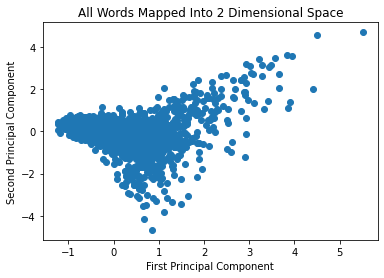

In [205]:
#PCA
pca = PCA(n_components=2)
word_vector = model.wv
word_vector_matrix = word_vector.vectors
pca.fit(word_vector_matrix)
print(pca.explained_variance_ratio_)

pca_data = pca.transform(word_vector_matrix)
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.title("All Words Mapped Into 2 Dimensional Space")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()